In [393]:
""" The following code is a simple implementation of a variational autoencoder, or VAE, in PyTorch.
The autoencoder is trained on the MNIST dataset. 
The code follows the following structure:
1. Import libraries, load and preprocess the data
2. Define the VAE architecture
3. Create an instance of the VAE and train it
4. Generate samples from the trained VAE
5. Visualize the results of compression and generation
6. Analyze the latent space of the VAE
7. Create a k-NN classifier on the latent space
"""

' The following code is a simple implementation of a variational autoencoder, or VAE, in PyTorch.\nThe autoencoder is trained on the MNIST dataset. '

In [394]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from keras.datasets import mnist
import random
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('mps')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [395]:
# LOAD AND PREPROCESS DATA

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and Reshape images (flatten)

x_train, x_test = torch.tensor(x_train.astype(
    'float32')/255.).to(device), torch.tensor(x_test.astype('float32')/255.).to(device)  # Normalize and convert to tensor
x_train_flat, x_test_flat = x_train.reshape(
    x_train.shape[0], -1).to(device), x_test.reshape(x_test.shape[0], -1).to(device)  # Reshape

# Create DataLoader

train_dataset = TensorDataset(x_train_flat)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_test_flat)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



In [396]:
# CREATE VARIATIONAL AUTOENCODER
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, layer_dims):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        
        for i in range(len(layer_dims) - 2):
            self.layers.append(nn.Linear(layer_dims[i], layer_dims[i + 1]))
            self.layers.append(nn.ReLU())
        
        self.linear_mu = nn.Linear(layer_dims[-2], layer_dims[-1])
        self.linear_logvar = nn.Linear(layer_dims[-2], layer_dims[-1])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, layer_dims):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList()
        
        reversed_dims = layer_dims[::-1]
        for i in range(len(reversed_dims) - 2):
            self.layers.append(nn.Linear(reversed_dims[i], reversed_dims[i + 1]))
            self.layers.append(nn.ReLU())
        
        self.output_layer = nn.Linear(reversed_dims[-2], reversed_dims[-1])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return self.sigmoid(x)


class VariationalAutoencoder(nn.Module):
    def __init__(self, layer_dims, BCE=True, KLD_weight=1.0):
        """
        Initializes a Variational Autoencoder object.

        Args:
            layer_dims (list): List of integers defining the architecture. For example, [784, 256, 2] defines a VAE with 784 input units, 256 hidden units, and 2 latent units.
            BCE (bool, optional): Whether to use Binary Cross Entropy loss. Defaults to True. If False, Mean Squared Error loss is used.
            KLD_weight (float, optional): The weight for the Kullback-Leibler Divergence loss term. Defaults to 1.0.
        """
        super(VariationalAutoencoder, self).__init__()
        self.KLD_weight = KLD_weight
        self.BCE = BCE
        self.latent_dim = layer_dims[-1]
        self.encoder = Encoder(layer_dims)
        self.decoder = Decoder(layer_dims)

    def sample(self, mu, logvar):
        std_dev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std_dev)
        return mu + eps * std_dev

    def loss(self, input, output, mu, logvar):
        if self.BCE:
            recon_loss = F.binary_cross_entropy(output, input, reduction='sum')
        else:
            recon_loss = F.mse_loss(output, input, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + self.KLD_weight * KLD

    def forward(self, x, y=None, output_latent=False):
        """
        Performs the forward pass of the variational autoencoder.

        Args:
            x (torch.Tensor): The input tensor.
            y (torch.Tensor, optional): The target tensor. Defaults to None.
            output_latent (bool, optional): Whether to output the latent representation. Defaults to False. If True, only the latent representation is returned.

        Returns:
            torch.Tensor or tuple: The output tensor or a tuple containing the output tensor and the loss.
        """
        mu, logvar = self.encoder(x)
        latent = self.sample(mu, logvar)
        if output_latent:
            return latent
        output = self.decoder(latent)
        if y is not None:
            loss = self.loss(x, output, mu, logvar)
            return output, loss
        return output

    def generate(self):
        latent = torch.randn(1, self.latent_dim).to(device)
        return self.decoder(latent)




In [397]:
# CREATE MODEL

# Model parameters:
layer_dims = [784, 784, 512, 264, 2]
KLD_weight = 0

model = VariationalAutoencoder(layer_dims=layer_dims, KLD_weight=KLD_weight, BCE=True).to(device)
model.to(device)
lossi = []  # Store loss values
val_lossi = []  # Store validation loss values

In [398]:
# TRAINING LOOP PARAMETERS

num_epochs = 100
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
validate = True
validate_every = 5

In [399]:


# TRAINING LOOP


for e in range(num_epochs):
    epoch_train_loss = 0
    model.train()
    for batch in tqdm(train_loader, desc=f"Epoch {e+1}/{num_epochs}"):
        x_batch = batch[0].to(device)

        output, loss = model(x=x_batch, y=x_batch)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        lossi.append(loss.item())
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    print(f'Epoch {e+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}')

    # Validation step (if applicable)
    if validate and e % validate_every == 0:
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                x_val_batch = val_batch[0].to(device)
                output, val_loss = model(x=x_val_batch, y=x_val_batch)
                val_lossi.append(val_loss.item())
                epoch_val_loss += val_loss.item()

        epoch_val_loss /= len(val_loader)
        print(f'Epoch {e+1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}')



Epoch 1/100: 100%|██████████| 938/938 [00:13<00:00, 68.79it/s]


Epoch 1/100, Training Loss: 10620.1909
Epoch 1/100, Validation Loss: 9353.9632


Epoch 2/100: 100%|██████████| 938/938 [00:13<00:00, 70.31it/s]


Epoch 2/100, Training Loss: 9195.5880


Epoch 3/100: 100%|██████████| 938/938 [00:13<00:00, 70.70it/s]


Epoch 3/100, Training Loss: 8984.9657


Epoch 4/100: 100%|██████████| 938/938 [00:13<00:00, 70.92it/s]


Epoch 4/100, Training Loss: 8821.5806


Epoch 5/100: 100%|██████████| 938/938 [00:12<00:00, 74.72it/s]


Epoch 5/100, Training Loss: 8797.3125


Epoch 6/100: 100%|██████████| 938/938 [00:12<00:00, 76.18it/s]


Epoch 6/100, Training Loss: 8640.3701
Epoch 6/100, Validation Loss: 8900.8029


Epoch 7/100: 100%|██████████| 938/938 [00:12<00:00, 73.31it/s]


Epoch 7/100, Training Loss: 8730.0348


Epoch 8/100: 100%|██████████| 938/938 [00:12<00:00, 73.50it/s]


Epoch 8/100, Training Loss: 8586.4281


Epoch 9/100: 100%|██████████| 938/938 [00:12<00:00, 75.97it/s]


Epoch 9/100, Training Loss: 8539.3360


Epoch 10/100: 100%|██████████| 938/938 [00:12<00:00, 77.19it/s]


Epoch 10/100, Training Loss: 8511.1937


Epoch 11/100: 100%|██████████| 938/938 [00:12<00:00, 75.93it/s]


Epoch 11/100, Training Loss: 8524.4467
Epoch 11/100, Validation Loss: 8511.3856


Epoch 12/100: 100%|██████████| 938/938 [00:12<00:00, 75.07it/s]


Epoch 12/100, Training Loss: 8573.5012


Epoch 13/100:  68%|██████▊   | 635/938 [00:08<00:04, 69.19it/s]

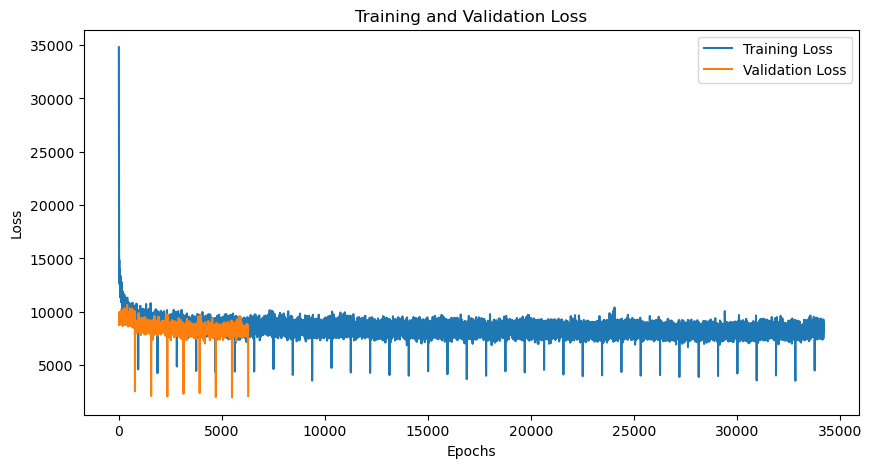

In [ ]:
# PLOT TRAINING AND VALIDATION LOSS

plt.figure(figsize=(10, 5))
plt.plot(lossi, label='Training Loss')
if validate:
    plt.plot(range(0, len(val_lossi) * 5, 5), val_lossi, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

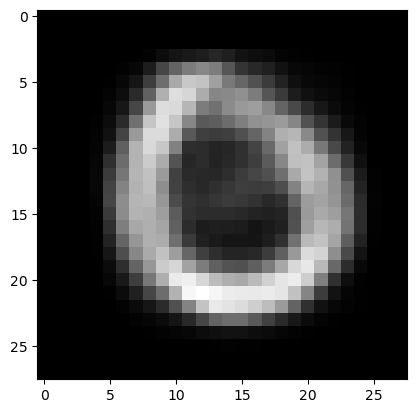

In [ ]:
# GENERATE SAMPLE

# Remember: a low KLD_weight will result in a more accurate reconstruction, but a less meaningful latent space, and vice versa. 

sample = model.generate()
plt.imshow(sample.reshape(28, 28).detach().cpu(), cmap='gray')
plt.show()

4


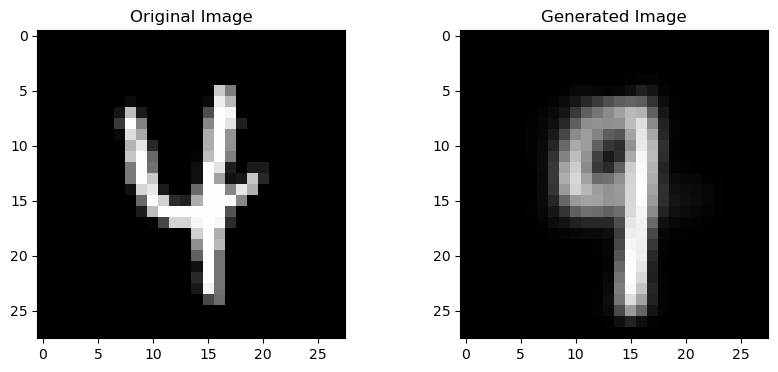

In [ ]:
# DISPLAY RANDOM ORIGINAL AND RECONSTRUCTED IMAGES

rand = random.randint(0, 9999)
output = model.forward(x_test_flat[rand])
print(y_test[rand])

# Display the original image
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(x_test_flat[rand].cpu().reshape(28, 28), cmap='gray')

# Display the generated image
output
plt.subplot(1, 2, 2)
plt.title("Generated Image")
plt.imshow(output.reshape(28, 28).detach().cpu(), cmap='gray')

plt.show()

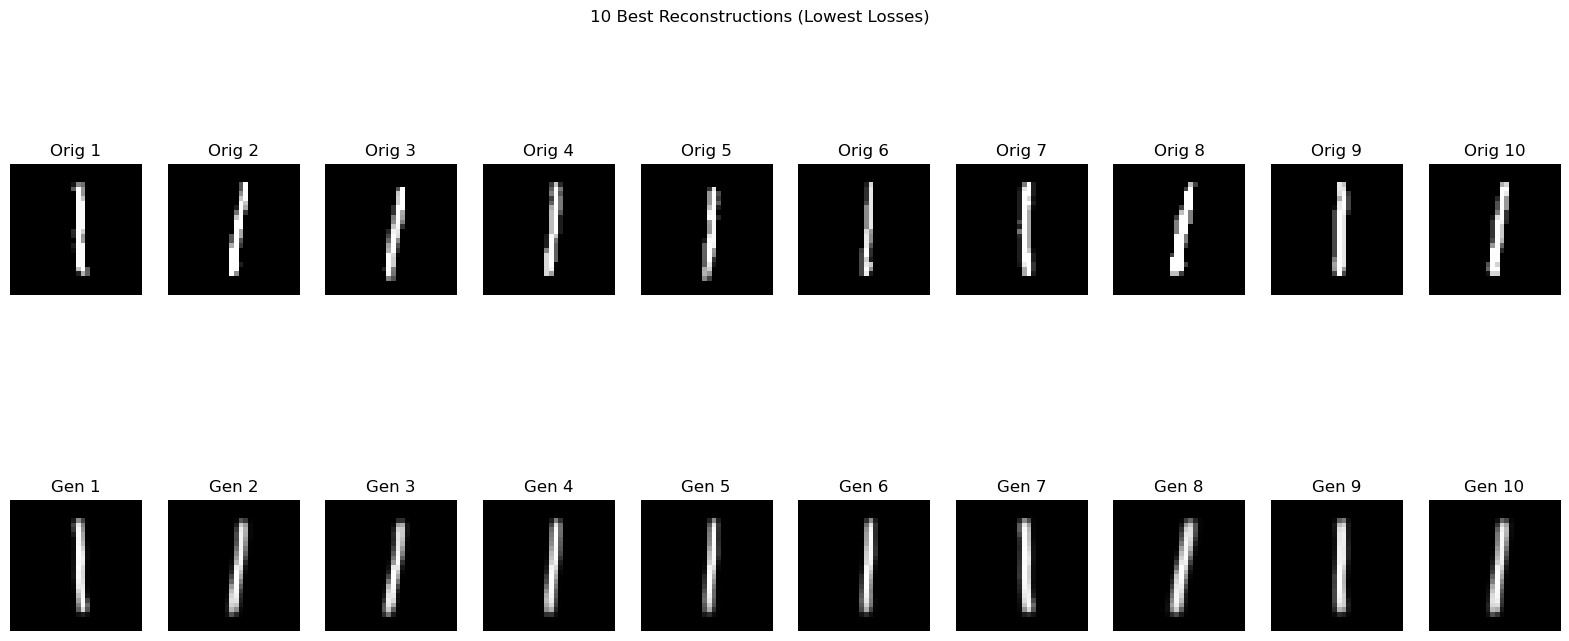

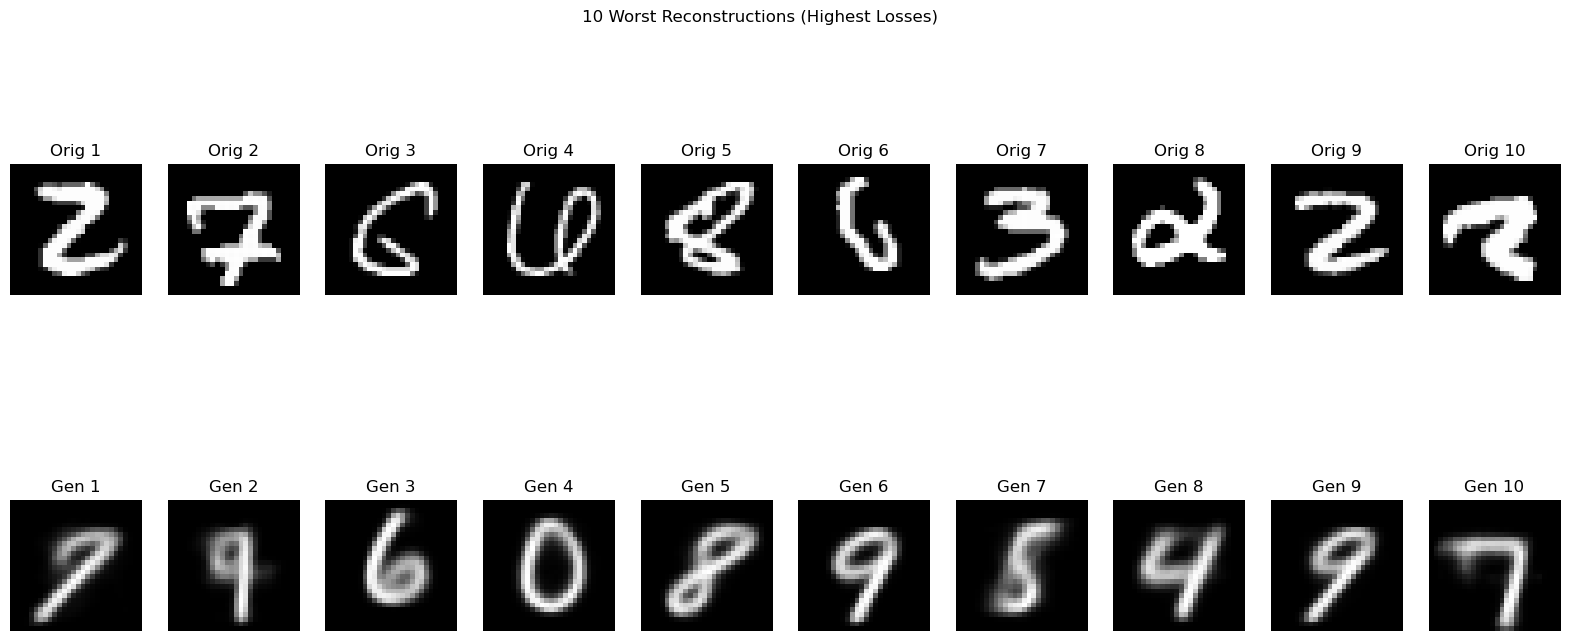

In [ ]:
# DISPLAY BEST AND WORST RECONSTRUCTIONS:
# Display the 10 best and 10 worst reconstructions based on loss


losses = []
outputs = []
for i in range(10000):
    output, loss = model(x=x_test_flat[i], y=x_test_flat[i])
    losses.append(loss.item())
    outputs.append(output)

losses = torch.tensor(losses)
outputs = torch.stack(outputs)

# Find indices of the 10 lowest and 10 highest losses
lowest_losses_indices = torch.argsort(losses)[:10]
highest_losses_indices = torch.argsort(losses, descending=True)[:10]

# Display the original and generated images with lowest losses
plt.figure(figsize=(20, 8))
for idx, i in enumerate(lowest_losses_indices):
    plt.subplot(2, 10, idx + 1)
    plt.title(f"Orig {idx+1}")
    plt.imshow(x_test_flat[i].cpu().reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 10, idx + 11)
    plt.title(f"Gen {idx+1}")
    plt.imshow(outputs[i].reshape(28, 28).detach().cpu(), cmap='gray')
    plt.axis('off')

plt.suptitle("10 Best Reconstructions (Lowest Losses)")
plt.show()

# Display the original and generated images with highest losses
plt.figure(figsize=(20, 8))
for idx, i in enumerate(highest_losses_indices):
    plt.subplot(2, 10, idx + 1)
    plt.title(f"Orig {idx+1}")
    plt.imshow(x_test_flat[i].cpu().reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 10, idx + 11)
    plt.title(f"Gen {idx+1}")
    plt.imshow(outputs[i].reshape(28, 28).detach().cpu(), cmap='gray')
    plt.axis('off')

plt.suptitle("10 Worst Reconstructions (Highest Losses)")
plt.show()

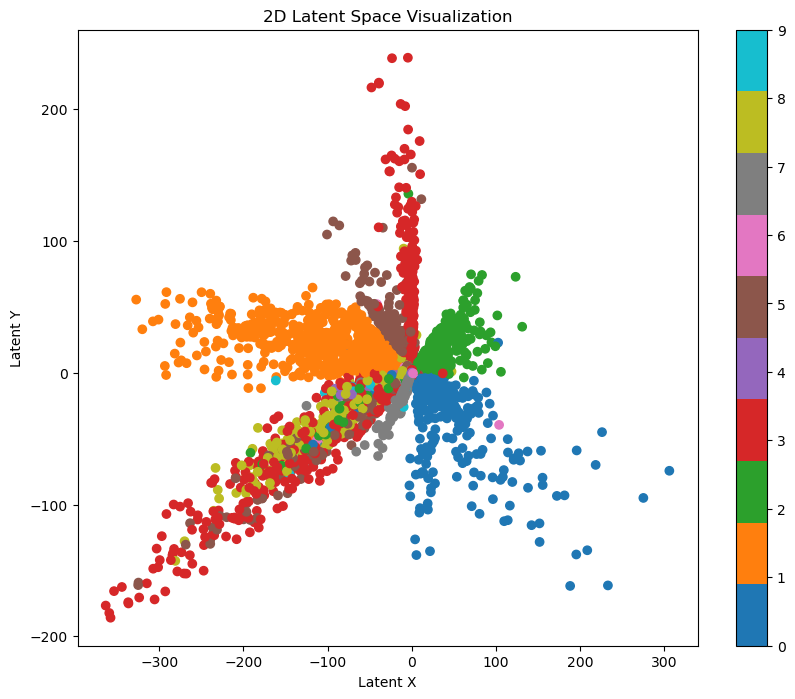

In [ ]:
# VISUALIZE LATENT SPACE


# In the case of a 2d latent space, we can visualize the latent space by plotting the color coded latent vectors of the test images
if model.latent_dim == 2:
    latent_vectors = model.forward(
        x_test_flat, output_latent=True).detach().cpu().numpy()
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_vectors[:, 0],
                latent_vectors[:, 1], c=y_test, cmap='tab10')
    plt.colorbar()
    plt.xlabel("Latent X")
    plt.ylabel("Latent Y")
    plt.title("2D Latent Space Visualization")
    plt.show()

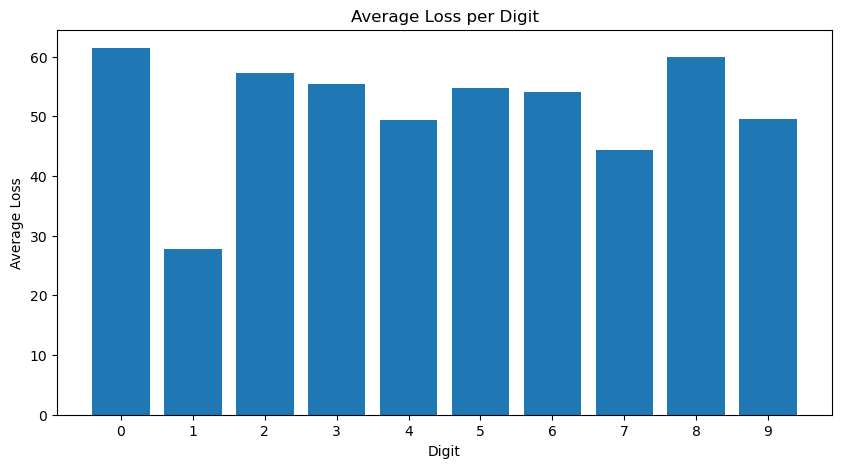

In [ ]:
# ANALYZE LOSS PER DIGIT


average_losses = []
for i in range(10):
    indices = (y_test == i)
    average_loss = torch.mean(losses[indices]).item()
    average_losses.append(average_loss)

plt.figure(figsize=(10, 5))
plt.bar(range(10), average_losses)
plt.xticks(range(10))
plt.xlabel("Digit")
plt.ylabel("Average Loss")
plt.title("Average Loss per Digit")
plt.show()

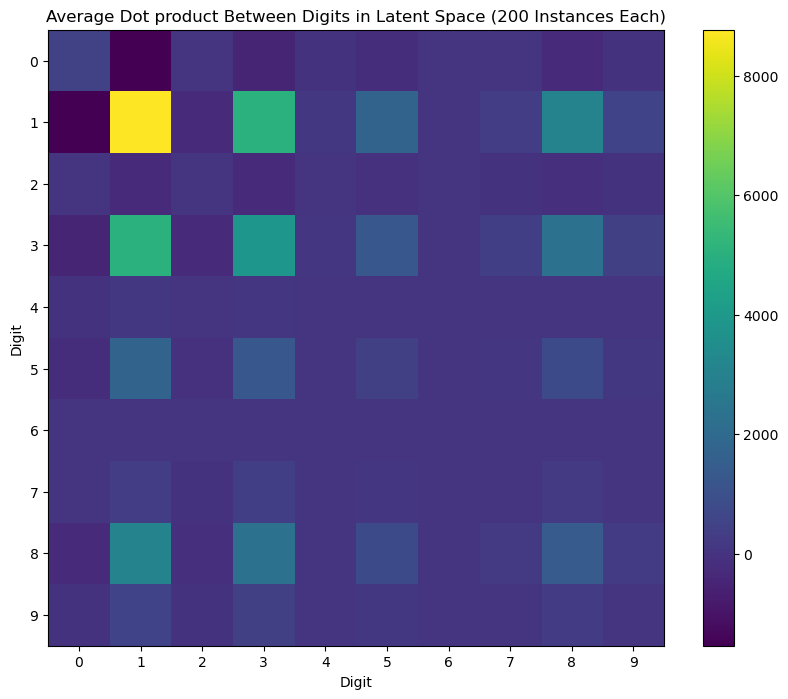

In [ ]:
# PLOT LATENT SPACE DISTANCES

# Function to plot the average distance between the latent space representations of each digit


def plot_latent_space_distances(model, x_test_flat, y_test, num_instances=10, metric='dot_product'):
    """
    Plots the average distance between digits in the latent space representation.

    Args:
        model (nn.Module): The trained variational autoencoder model.
        x_test_flat (torch.Tensor): Flattened test data.
        y_test (torch.Tensor): Labels of the test data.
        num_instances (int, optional): Number of instances to consider for each digit. Defaults to 10.
        metric (str, optional): The distance metric to use. Can be 'dot_product', 'euclidean', 'manhattan', or 'cosine'. Defaults to 'dot_product'.

    Raises:
        ValueError: If an unknown metric is provided.

    Returns:
        None
    """
    instances = []
    for i in range(10):
        indices = (y_test == i)
        # Get num_instances for each digit
        digit_instances = x_test_flat[indices][:num_instances]
        instances.append(digit_instances)

    # Concatenate all instances
    instances = torch.cat(instances)
    # Flatten the instances if not already
    instances = instances.view(-1, x_test_flat.shape[1])

    # Calculate latent space representation of each instance
    latent_vectors = model.forward(
        instances, output_latent=True).detach().cpu().numpy()

    # Reshape latent vectors to have a separate axis for each digit
    latent_vectors = latent_vectors.reshape(10, num_instances, -1)

    # Calculate the desired metric between each digit's latent space representation and all other digits
    average_distances = np.zeros((10, 10))

    for i in range(10):
        for j in range(10):
            if metric == 'dot_product':
                distance = np.mean([np.dot(latent_vectors[i, k], latent_vectors[j, l]) for k in range(
                    num_instances) for l in range(num_instances)])
            elif metric == 'euclidean':
                distance = np.mean([np.linalg.norm(latent_vectors[i, k] - latent_vectors[j, l])
                                   for k in range(num_instances) for l in range(num_instances)])
            elif metric == 'manhattan':
                distance = np.mean([np.sum(np.abs(latent_vectors[i, k] - latent_vectors[j, l]))
                                   for k in range(num_instances) for l in range(num_instances)])
            elif metric == 'cosine':
                distance = np.mean([cosine_similarity(latent_vectors[i, k].reshape(
                    1, -1), latent_vectors[j, l].reshape(1, -1))[0][0] for k in range(num_instances) for l in range(num_instances)])
            else:
                raise ValueError(f"Unknown metric: {metric}")
            average_distances[i, j] = distance

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(average_distances, cmap='viridis')
    plt.colorbar()
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.xlabel("Digit")
    plt.ylabel("Digit")
    plt.title(
        f"Average {metric.replace('_', ' ').capitalize()} Between Digits in Latent Space ({num_instances} Instances Each)")
    plt.show()



plot_latent_space_distances(
    model, x_test_flat, y_test, num_instances=200, metric='dot_product')

Accuracy of the k-nearest neighbors classifier: 0.20


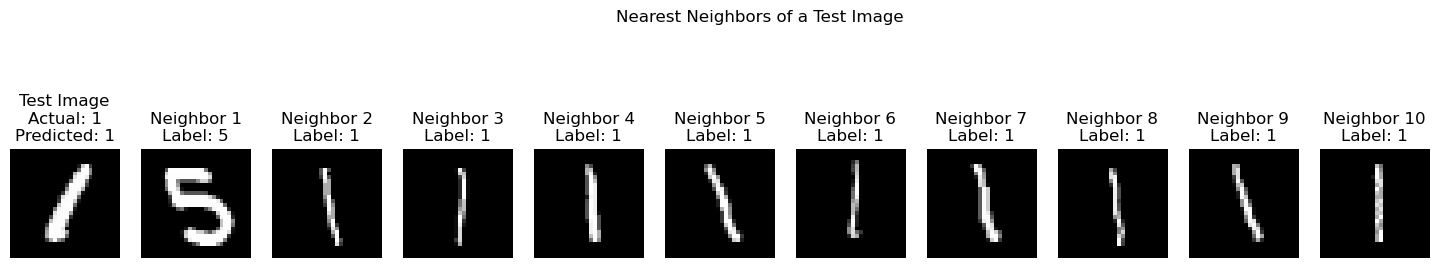

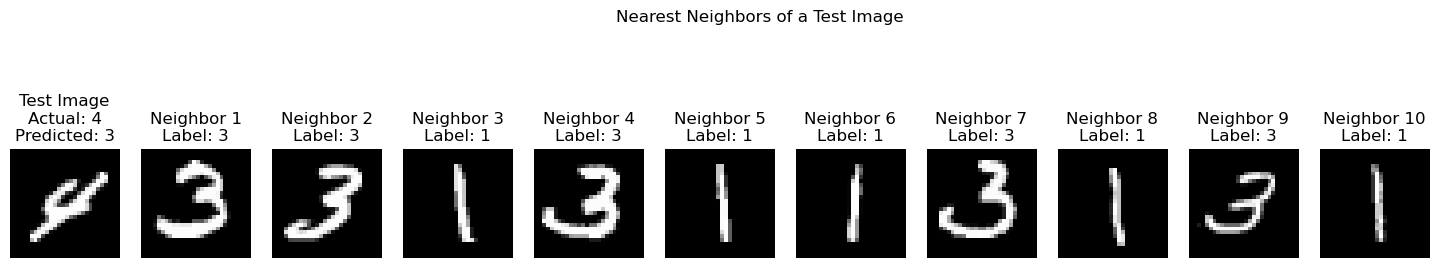

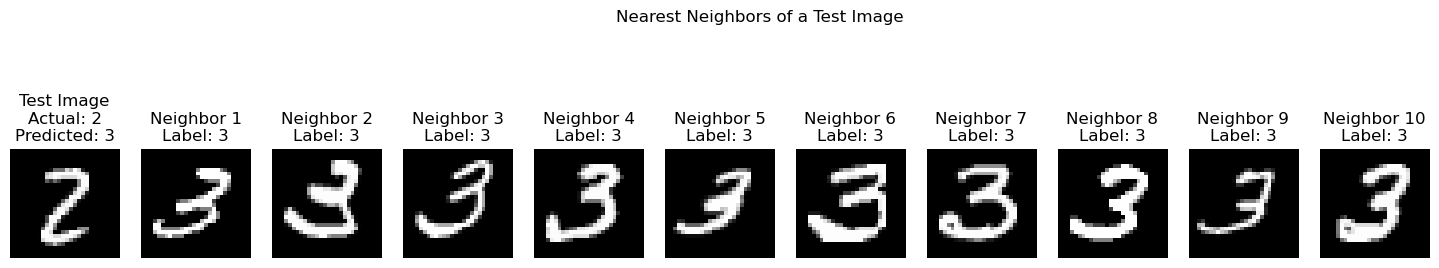

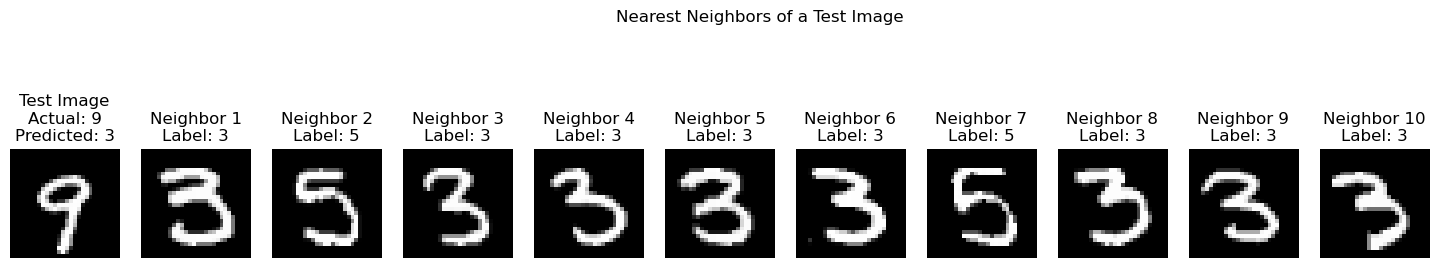

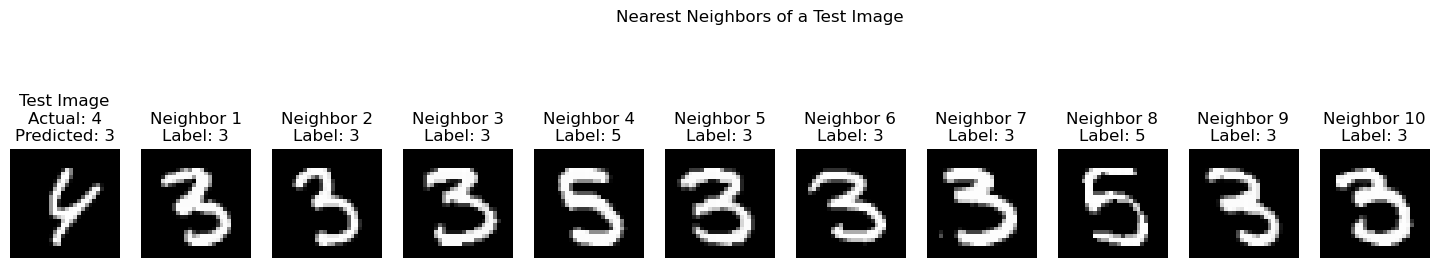

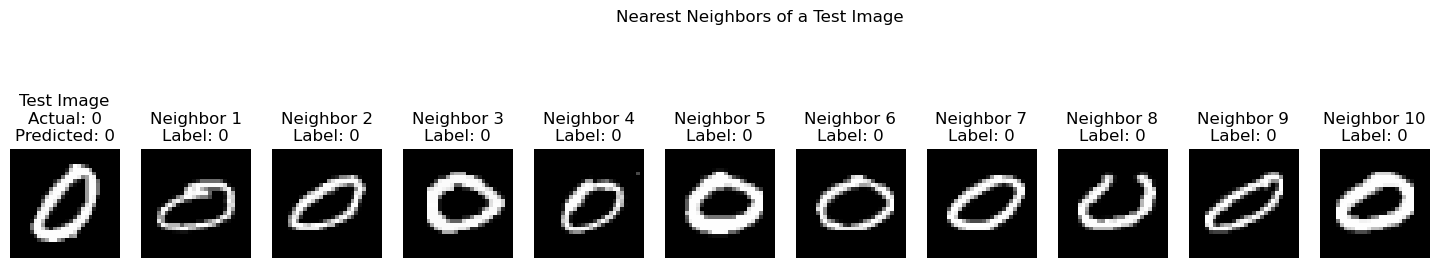

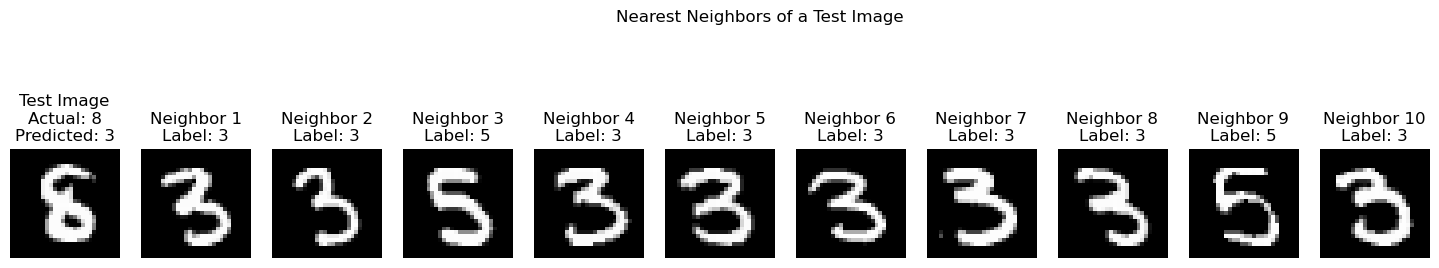

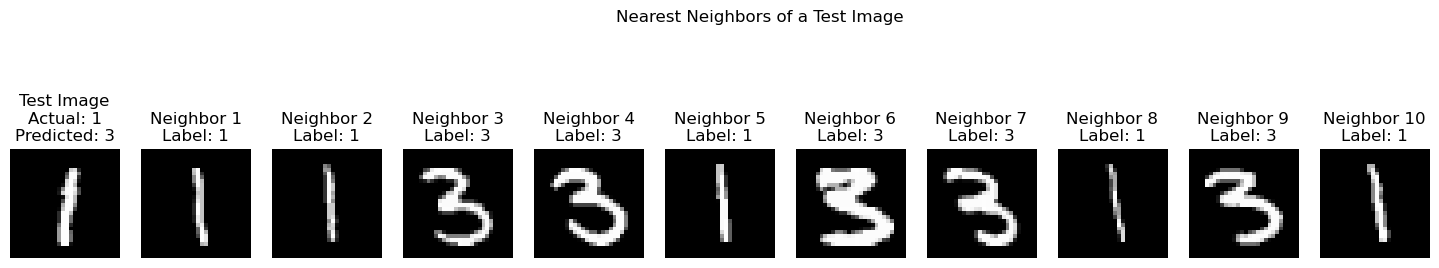

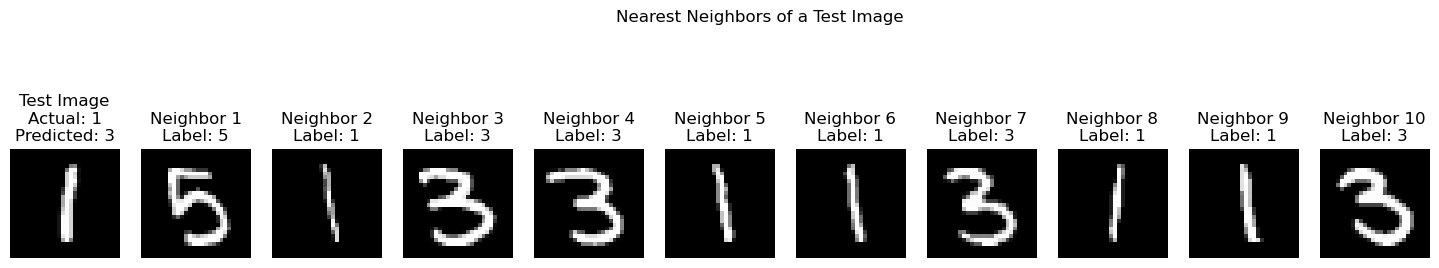

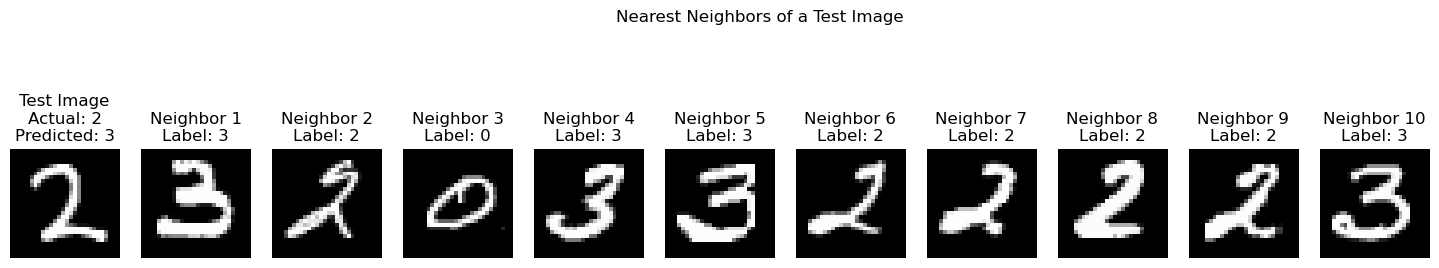

In [ ]:
# IMPLEMENT K-NEAREST NEIGHBORS CLASSIFIER USING LATENT SPACE REPRESENTATIONS


def knn_classifier(num_test_images=1, k=5, display_k_nearest=10, training_cutoff=10000, similarity_metric='cosine'):
    x_train_subset = x_train_flat[:training_cutoff]
    y_train_subset = y_train[:training_cutoff]

    # Calculate the latent space representation of the training images subset
    latent_vectors_train = model.forward(
        x_train_subset, output_latent=True).detach().cpu().numpy()

    random_indices = random.sample(range(len(x_test_flat)), num_test_images)
    x_test_subset = x_test_flat[random_indices]
    y_test_subset = y_test[random_indices]

    # Calculate the latent space representation of the test images
    latent_vectors_test = model.forward(
        x_test_subset, output_latent=True).detach().cpu().numpy()

    # Use the specified similarity metric to find the nearest neighbors
    if similarity_metric == 'cosine':
        similarities = cosine_similarity(
            latent_vectors_test, latent_vectors_train)
    elif similarity_metric == 'dot':
        similarities = np.dot(latent_vectors_test, latent_vectors_train.T)
    else:
        raise ValueError(
            "Invalid similarity metric. Choose 'cosine' or 'dot'.")

    # Find the indices of the k-nearest neighbors
    nearest_neighbor_indices = np.argsort(similarities, axis=1)[:, -k:]

    # Get the labels of the k-nearest neighbors
    nearest_neighbor_labels = y_train_subset[nearest_neighbor_indices]

    # Predict the label of each test image as the most common label among its k-nearest neighbors
    predicted_labels, _ = mode(nearest_neighbor_labels, axis=1)

    # Flatten the predicted labels
    predicted_labels = predicted_labels.flatten()

    # Calculate the accuracy of the classifier
    accuracy = np.mean(predicted_labels == y_test_subset)
    print(f"Accuracy of the k-nearest neighbors classifier: {accuracy:.2f}")

    for idx, rand in enumerate(random_indices):
        test_image = x_test_flat[rand].cpu().numpy()
        nearest_neighbor_indices_for_image = nearest_neighbor_indices[idx]
        nearest_neighbor_images = x_train_subset[nearest_neighbor_indices_for_image]

        plt.figure(figsize=(20, 4))
        plt.subplot(1, display_k_nearest + 2, 1)
        plt.title(
            f"Test Image\nActual: {y_test_subset[idx]}\nPredicted: {predicted_labels[idx]}")
        plt.imshow(test_image.reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Display only the specified number of nearest neighbors
        for i in range(min(display_k_nearest, k)):
            plt.subplot(1, display_k_nearest + 2, i + 2)
            plt.title(
                f"Neighbor {i + 1}\nLabel: {nearest_neighbor_labels[idx][i]}")
            plt.imshow(nearest_neighbor_images[i].reshape(
                28, 28).cpu().numpy(), cmap='gray')
            plt.axis('off')

        plt.suptitle("Nearest Neighbors of a Test Image")
        plt.show()


knn_classifier(num_test_images=10, k=50, display_k_nearest=10,
               training_cutoff=59999, similarity_metric='dot')